## PUBG Modelling

플레이어들이 전장에서 벌이는 모든 행위를 분류하여 승리를 예측하기 위한 프로젝트

## Column 별 정보
- ASSISTS : 자신에 의해 사살되지는 못했지만 자신의 데미지 지분율이 가장 높은 적의 수
- BOOSTS : 도핑 아이템 사용 횟수(에너지 드링크, 진통제, 아드레날린 주사기)
- DAMAGEDEALT : 적에게 가한 전체 데미지
- DBNOS : 기절시킨 적의 수
- GROUPID : 경기 내 그룹 식별 ID
- HEADSHOTKILLS : 헤드샷으로 죽인 적의 수
- HEALS : 회복 아이템 사용 횟수(붕대, 구급상자, 의료용 키트)
- ID : 해당 데이터 ID
- KILLPLACE : 경기 내 적을 죽인 적 수의 순위
- KILLPOINTS : 유저의 ELO레이팅(죽인 적 수 기반)
- KILLS : 경기 내 적을 죽인 수
- KILLSTREAKS : 짧은 시간 내에 연속으로 적을 죽인 수
- LONGESTKILL : 사살한 적까지의 거리의 최대값
- MATCHDURATION : 경기가 진행된 시간(단위:초)
- MATCHID : 경기 식별 ID
- MATCHTYPE : 경기 모드( ex: 솔로, 듀오, 스쿼드 )
- MAXPLACE : 경기 내 총 인원 수
- NUMGROUP : 경기 내 실제 참여 인원 수
- RANKPOINTS : 유저의 ELO 레이팅
- REVIVES : 유저가 팀원을 부활시킨 횟수
- RIDEDISTANCE : 이동수단을 통해 이동한 거리(단위:m)
- ROADKILLS : 이동수단으로 살해한 적의 수
- SWIMDISTANCE : 수영으로 이동한 거리(단위:m)
- TEAMKILLS : 같은 팀원을 살해한 수
- VEHICLEDESTROYS : 파괴한 이동수단의 수
- WALKDISTANCE : 도보로 이동한 거리(단위:m)
- WEAPONSACQUIRED : 획득한 무기의 수
- WINPOINTS : 유저의 ELO 레이팅(승리 횟수 기반)
- WINPLACEPERC : 현재 경기에서의 백분위 기반 유저의 순위(종속변수)

## 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy import stats

import sys
import warnings                      
warnings.filterwarnings("ignore")

import os
import gc
print(os.listdir("./data/pubg-finish-placement-prediction/"))

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


In [2]:
train = pd.read_csv("./data/pubg-finish-placement-prediction/train_V2.csv")
test = pd.read_csv("./data/pubg-finish-placement-prediction/test_V2.csv")

In [3]:
print(train.shape, test.shape)

(4446966, 29) (1934174, 28)


In [83]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [7]:
train[train.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [8]:
train = train.dropna(axis=0)

In [9]:
train = train.drop(["Id", "groupId","matchId"], axis=1)

- Id, groupId, matchId 들은 예측에 전혀 필요가 없는 컬럼이므로 드랍

In [10]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,...,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [11]:
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [12]:
group_lists = ["squad-fpp","squad","normal-squad-fpp","normal-squad","duo-fpp","duo","normal-duo-fpp","normal-duo"]
train_group = train.loc[train["matchType"].isin(group_lists)]
solo_lists = ["solo-fpp","solo","normal-solo-fpp","normal-solo"]
train_solo = train.loc[train["matchType"].isin(solo_lists)]

## 데이터 분석

## Column별 분석

### Kills & DamageDealt & Assists

##### Kills & DamageDealt

In [13]:
train['kills'].quantile(0.99)

7.0

In [14]:
train['kills'].value_counts()

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2
49          1
45          1
47          1
48          1
50          1
66          1
65          1
72          1
Name: kills, dtype: int64

In [15]:
kills= train.copy()
kills.loc[kills['kills'] >= 8] = '8+'
train_ks = kills.loc[:,"kills"].value_counts().to_frame().reset_index()
train_ks.columns = ["Type","Count"]
train_ks

,Type,Count
0,0,2529721
1,1,928079
2,2,472466
3,3,232441
4,4,124543
5,5,66577
6,6,37960
7,8+,33362
8,7,21816


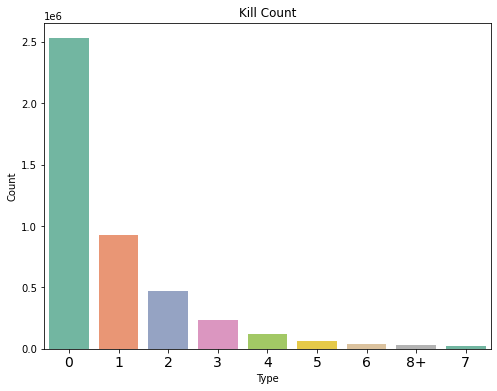

In [16]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Kill Count")
plt.show()

- 대다수의 사람들이 0킬이나 1킬을 한것으로 보여진다

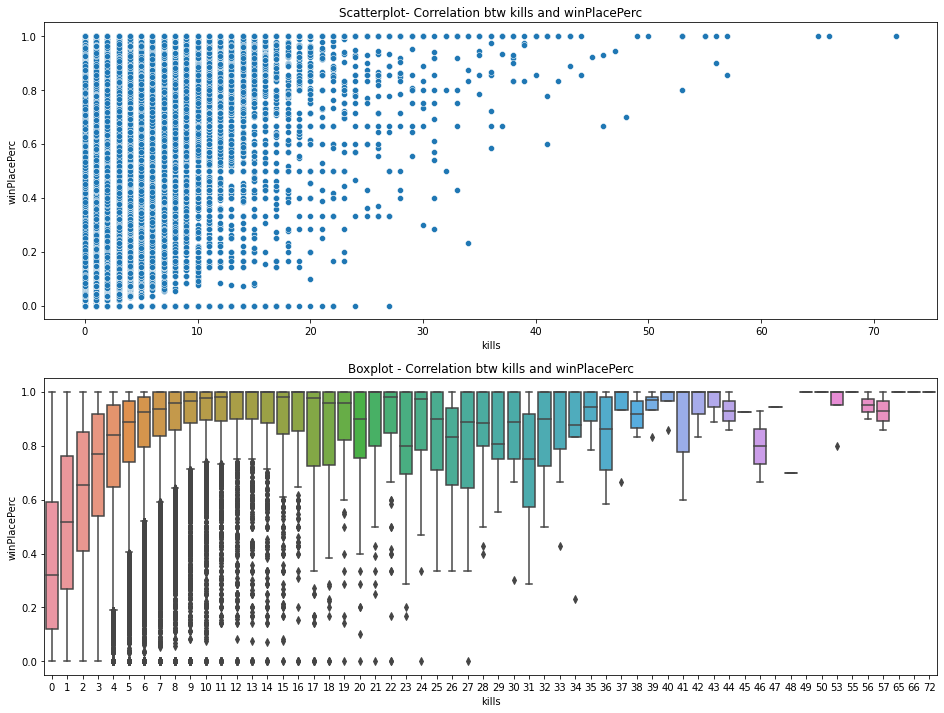

In [113]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='kills', y='winPlacePerc')
plt.title("Scatterplot- Correlation btw kills and winPlacePerc")
plt.subplot(212)
sns.boxplot(data=train, x='kills', y='winPlacePerc')
plt.title("Boxplot - Correlation btw kills and winPlacePerc")
plt.show()

- 킬수와 승리와의 상관관계는 존재한다
- 킬수가 높을수록 승리할 확률이 높다

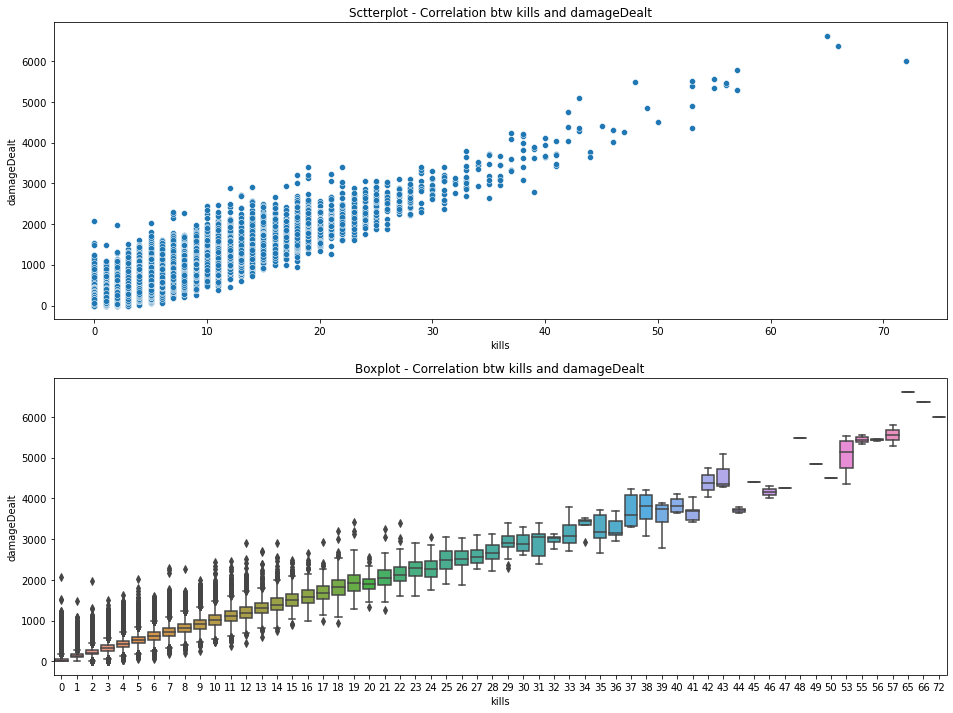

In [112]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x="kills", y="damageDealt")
plt.title("Sctterplot - Correlation btw kills and damageDealt")
plt.subplot(212)
sns.boxplot(data=train, x="kills", y="damageDealt")
plt.title("Boxplot - Correlation btw kills and damageDealt")
plt.show()

- 킬수와 데미지는 양의 상관관계를 가진다 
- 킬수가 높을수록 데미지가 높다

In [19]:
train[train.kills>60]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
334400,20,0,6616.0,0,13,5,1,0,65,7,...,0,0.0,0,0.0,0,0,1036.0,60,0,1.0
1248348,5,0,6375.0,0,21,4,1,0,66,8,...,0,0.0,0,0.0,0,0,1740.0,23,0,1.0
3431247,7,4,5990.0,0,64,10,1,0,72,7,...,0,0.0,0,0.0,0,0,728.1,35,0,1.0


- 60킬 이상 한사람들의 데이터를 보면 걸은 거리가 그렇게 많지는 않은데 
- 한곳에 여러명이 떨어져서 그 지역에서 킬을 몰아서 먹은것으로 예상된다
- 아니면 불법 프로그램을 사용했을까?

In [20]:
train[(train['kills'] == 0) & (train['winPlacePerc'] == 1.0)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
107,1,1,58.360,0,0,2,38,0,0,0,...,0,5134.0,0,0.0,0,0,2708.0,7,0,1.0
118,2,6,76.110,0,0,12,45,0,0,0,...,1,0.0,0,0.0,0,0,2635.0,7,0,1.0
493,1,3,275.900,0,0,2,44,0,0,0,...,0,2293.0,0,0.0,0,0,2537.0,4,0,1.0
1225,1,3,3.669,0,0,3,36,1019,0,0,...,0,1298.0,0,0.0,0,0,1751.0,6,1511,1.0
1289,2,2,126.800,0,0,1,44,1337,0,0,...,0,0.0,0,0.0,0,0,1458.0,3,1550,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445253,1,3,125.600,1,0,4,43,1509,0,0,...,0,807.1,0,0.0,0,0,2798.0,6,1476,1.0
4445751,1,3,124.700,0,0,0,40,0,0,0,...,0,0.0,0,0.0,0,0,2253.0,6,0,1.0
4446093,0,0,116.800,0,0,0,3,0,0,0,...,0,0.0,0,0.0,0,0,0.0,11,0,1.0
4446823,0,3,49.500,0,0,0,45,1639,0,0,...,0,0.0,0,0.0,0,0,4307.0,5,1623,1.0


In [21]:
train[(train['kills'] <= 1.0) & (train['winPlacePerc'] == 1.0)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
107,1,1,58.36,0,0,2,38,0,0,0,...,0,5134.0,0,0.0,0,0,2708.0,7,0,1.0
118,2,6,76.11,0,0,12,45,0,0,0,...,1,0.0,0,0.0,0,0,2635.0,7,0,1.0
341,0,6,91.00,0,1,0,29,0,1,1,...,0,4427.0,0,0.0,0,0,2348.0,4,0,1.0
396,0,9,235.70,0,0,5,22,1427,1,1,...,3,4439.0,0,0.0,0,0,3408.0,9,1460,1.0
493,1,3,275.90,0,0,2,44,0,0,0,...,0,2293.0,0,0.0,0,0,2537.0,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446261,1,6,133.80,1,0,13,22,1447,1,1,...,1,13800.0,0,0.0,0,0,2444.0,4,1649,1.0
4446639,0,2,301.90,2,1,4,18,0,1,1,...,0,5352.0,0,0.0,0,0,2299.0,6,0,1.0
4446823,0,3,49.50,0,0,0,45,1639,0,0,...,0,0.0,0,0.0,0,0,4307.0,5,1623,1.0
4446831,0,5,208.70,1,0,3,35,0,0,0,...,0,3811.0,0,221.9,0,0,4589.0,6,0,1.0


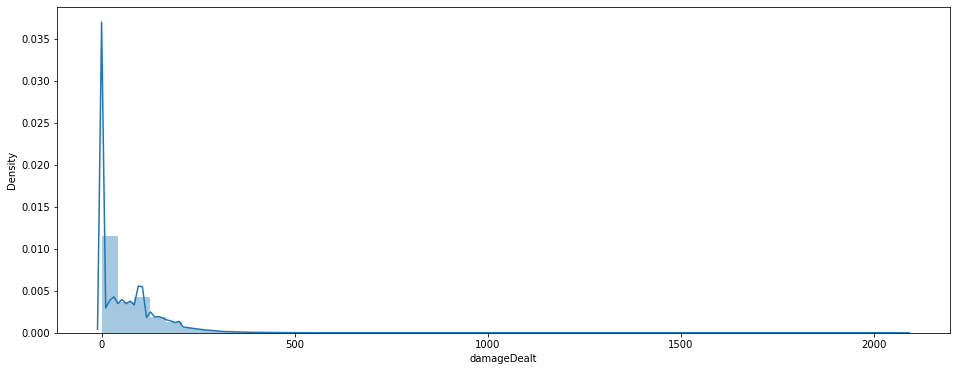

In [114]:
df = train.copy()
df = df[df['kills']<=1]

plt.figure(figsize=(16,6))
sns.distplot(df['damageDealt'])
plt.show()

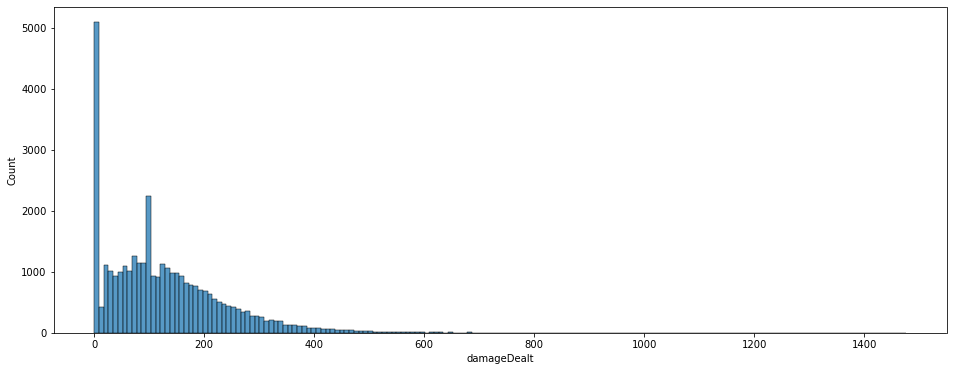

In [115]:
df = df[df['winPlacePerc'] == 1.0]
plt.figure(figsize=(16,6))
sns.histplot(data=df, x='damageDealt')
plt.show()

In [24]:
df1 = df[df['damageDealt']==0]
print(len(df), len(df1))

35349 4765


In [25]:
df1['matchType'].value_counts()

squad-fpp           2705
squad               1229
solo                 313
duo-fpp              297
duo                  125
normal-squad-fpp      70
crashfpp               9
normal-duo-fpp         6
normal-squad           3
crashtpp               3
solo-fpp               1
flaretpp               1
normal-duo             1
normal-solo            1
normal-solo-fpp        1
Name: matchType, dtype: int64

In [26]:
df1[df1['matchType'].str.contains('squad')]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2931,0,2,0.0,0,0,0,46,1414,0,0,...,0,0.0,0,0.0000,0,0,2854.00,5,1598,1.0
3114,0,0,0.0,0,0,0,38,0,0,0,...,0,0.0,0,0.0000,0,0,18.65,1,0,1.0
3571,0,4,0.0,0,0,5,40,0,0,0,...,0,5631.0,0,0.0000,0,1,2440.00,5,0,1.0
5288,0,2,0.0,0,0,10,44,0,0,0,...,0,2868.0,0,0.0000,0,0,1385.00,3,0,1.0
5910,0,3,0.0,0,0,3,48,1165,0,0,...,0,0.0,0,57.2600,0,0,2348.00,5,1504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438796,0,0,0.0,0,0,0,45,0,0,0,...,0,5798.0,0,0.0000,0,0,1203.00,6,0,1.0
4442844,0,1,0.0,0,0,0,32,0,0,0,...,0,0.0,0,0.0000,0,0,531.10,2,0,1.0
4442954,0,0,0.0,0,0,0,28,0,0,0,...,0,0.0,0,0.0000,0,0,575.50,4,0,1.0
4443682,1,5,0.0,0,0,2,37,1030,0,0,...,2,880.1,0,0.0000,0,0,3998.00,9,1487,1.0


In [27]:
df1[df1['matchType'].str.contains('duo')]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
8816,2,2,0.0,0,0,0,40,0,0,0,...,0,0.000,0,0.000,0,0,2627.0,6,0,1.0
19925,0,4,0.0,0,0,3,17,1267,0,0,...,0,0.000,0,0.000,0,0,3671.0,4,1542,1.0
27196,0,3,0.0,0,0,6,37,0,0,0,...,0,0.000,0,0.000,0,0,2882.0,6,0,1.0
30235,0,1,0.0,0,0,0,38,0,0,0,...,0,4670.000,0,0.000,0,0,2145.0,4,0,1.0
31618,0,4,0.0,0,0,0,44,0,0,0,...,0,0.000,0,0.000,0,0,3610.0,6,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391594,1,5,0.0,0,0,7,39,0,0,0,...,0,6524.000,0,0.000,0,0,3604.0,7,0,1.0
4394774,0,4,0.0,0,0,0,41,1214,0,0,...,0,0.012,0,6.263,0,0,5038.0,4,1508,1.0
4404200,1,4,0.0,0,0,4,34,1068,0,0,...,0,797.900,0,0.000,0,0,2702.0,8,1542,1.0
4410111,0,0,0.0,0,0,0,37,1075,0,0,...,0,0.000,0,0.000,0,0,3802.0,4,1560,1.0


In [28]:
df1[df1['matchType'].str.contains('solo')]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3702,0,0,0.0,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0,0.0,3,0,1.0
8790,0,0,0.0,0,0,0,2,0,0,0,...,0,0.0,0,0.0,0,0,0.0,1,0,1.0
18426,0,1,0.0,0,0,0,2,0,0,0,...,0,0.0,0,0.0,0,0,0.0,6,0,1.0
20114,0,0,0.0,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0,0.0,6,0,1.0
29291,0,0,0.0,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0,0.0,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427111,0,0,0.0,0,0,0,3,0,0,0,...,0,0.0,0,0.0,0,0,0.0,2,0,1.0
4428430,0,0,0.0,0,0,0,3,0,0,0,...,0,0.0,0,0.0,0,0,0.0,7,0,1.0
4428507,0,0,0.0,0,0,0,3,0,0,0,...,0,0.0,0,0.0,0,0,0.0,18,0,1.0
4430451,0,0,0.0,0,0,0,2,0,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0,1.0


In [29]:
df1['matchType'].str.contains('squad').sum()

4007

In [30]:
df1_squad = df1['matchType'].str.contains('squad').sum()
df1_duo = df1['matchType'].str.contains('duo').sum()
df1_solo = df1['matchType'].str.contains('solo').sum()
df1_mt = pd.DataFrame([df1_squad,df1_duo,df1_solo], index=["squad","duo","solo"], columns =["count"])
df1_mt

,count
squad,4007
duo,429
solo,316


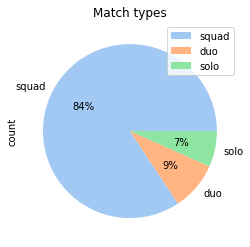

In [31]:
palette = sns.color_palette('pastel')
df1_mt.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- 데미지가 0으로 우승한 사람들은 squad가 대부분이다
- 솔로에서 데미지가 0으로 우승한 사람들 316명은 핵으로 취급하거나
- 운이 좋아서 아무것도 안하고 이겼다고 볼수있을거 같다 (e.g. 마지막 한명이 자기장밖에서 죽거나, 마지막 두명이 서로 싸우다 자멸하거나)

- 킬수와 승리의 상관관계는 존재한다
- 킬수가 높을수록 승리를 할 확률이 높다
- 킬수와 데미지의 상관관계는 존재한다
- 킬수가 높을수록 데미지가 높다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 좋은 팀을 만나 승리한것으로 보여진다
- 킬수가 낮거나 없는 사람들중에 승리한 사람들은 데미지를 제대로 주지 못한것으로 보여진다
- 그야말로 팀원 덕분에 승리한거라고 할수있다

##### Assists

In [32]:
train_group['assists'].quantile(0.99)

3.0

In [33]:
train_group['assists'].value_counts()

0     2978830
1      553245
2      134856
3       35260
4        9812
5        2801
6         920
7         338
8         157
9          68
10         38
11         17
12         12
13         10
15          5
14          2
17          1
Name: assists, dtype: int64

In [34]:
assists= train_group.copy()
assists.loc[assists['assists'] >= 4] = '4+'
train_ast = assists.loc[:,"assists"].value_counts().to_frame().reset_index()
train_ast.columns = ["Type","Count"]
train_ast

,Type,Count
0,0,2978830
1,1,553245
2,2,134856
3,3,35260
4,4+,14181


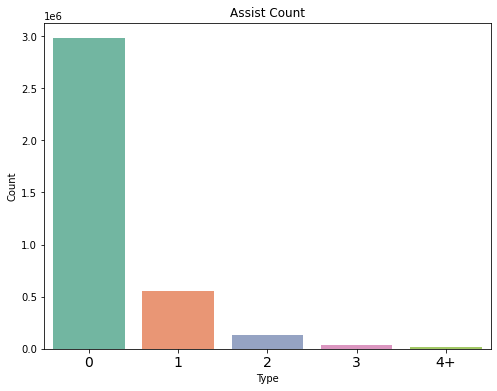

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_ast, palette="Set2")
plt.xticks(fontsize=14)
plt.title("Assist Count")
plt.show()

- 대다수가 0에서 1 어시스트를 했다

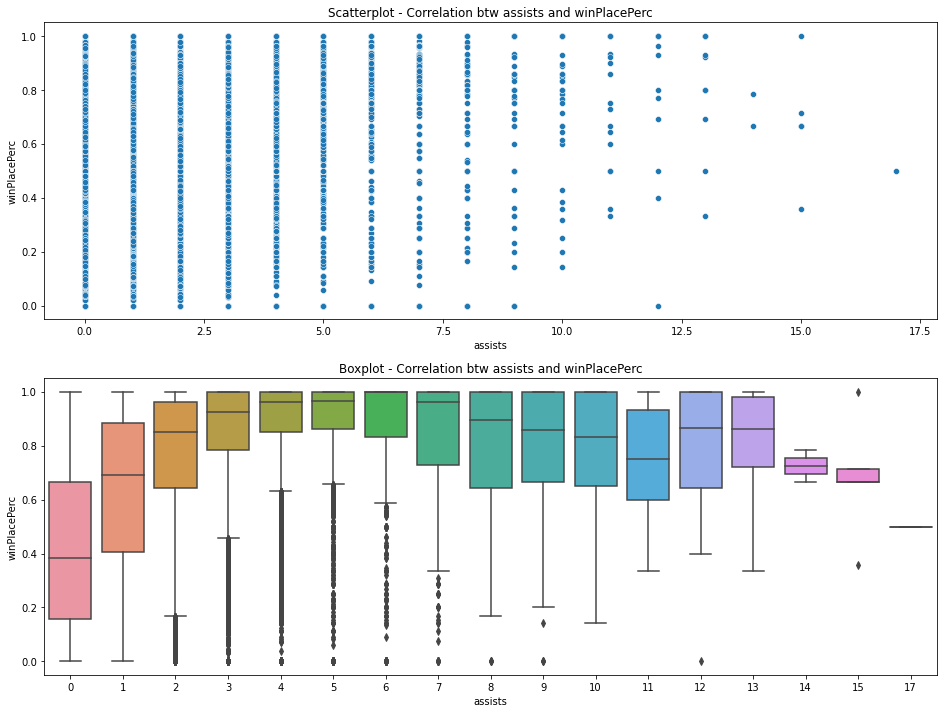

In [117]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train_group, x='assists', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw assists and winPlacePerc")
plt.subplot(212)
sns.boxplot(data=train_group, x='assists', y='winPlacePerc')
plt.title("Boxplot - Correlation btw assists and winPlacePerc")
plt.show()

- 어시스트와 승리와의 뚜렷한 상관관계는 보이지 않는것 같다

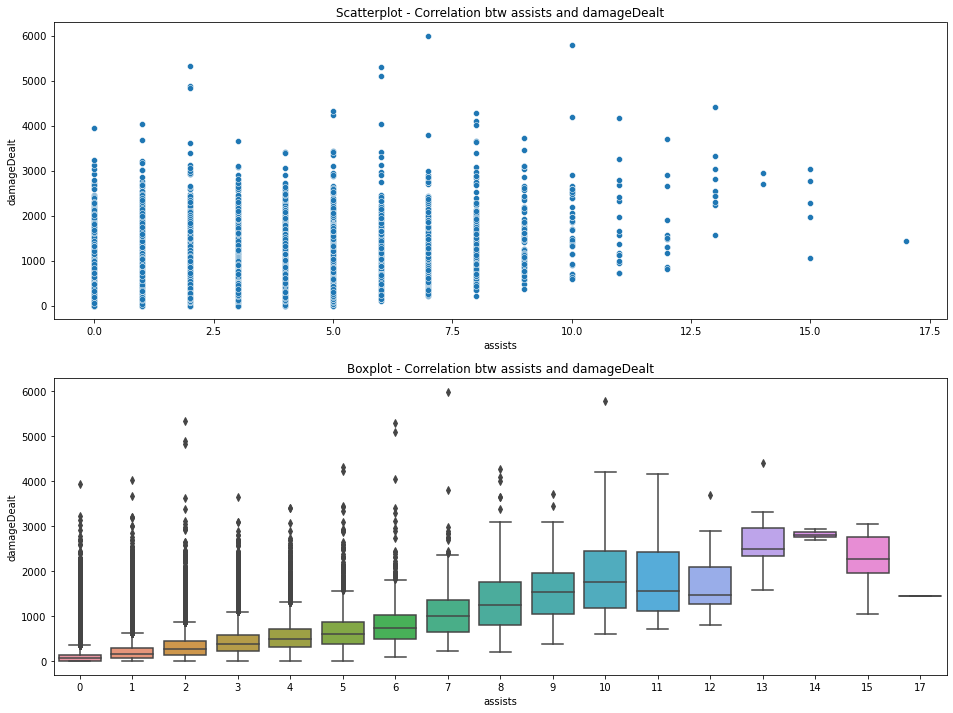

In [118]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train_group, x='assists', y='damageDealt')
plt.title("Scatterplot - Correlation btw assists and damageDealt")
plt.subplot(212)
sns.boxplot(data=train_group, x='assists', y='damageDealt')
plt.title("Boxplot - Correlation btw assists and damageDealt")
plt.show()

- 어시스트와 데미지와의 뚜렷한 상관관계는 보이지 않는것 같다

### DBNOS & headshotKills & LongestKill & Killstreaks & teamKills

#### DBNOs

In [38]:
train_group['DBNOs'].quantile(0.99)

5.0

In [39]:
train_group.DBNOs.value_counts()

0     2046858
1      980807
2      394313
3      162429
4       69210
5       31645
6       14959
7        7282
8        3686
9        1962
10       1109
11        642
12        465
13        274
14        177
15        137
16         87
17         79
18         64
19         33
20         30
21         25
22         18
25         16
23         14
26         11
24         10
33          7
27          6
32          3
31          3
28          3
39          2
38          1
30          1
29          1
35          1
40          1
53          1
Name: DBNOs, dtype: int64

In [40]:
dbnos = train_group.copy()
dbnos.loc[dbnos['DBNOs'] >= 6] = '6+'
train_dbnos = dbnos.loc[:,"DBNOs"].value_counts().to_frame().reset_index()
train_dbnos.columns = ["Type","Count"]
train_dbnos

,Type,Count
0,0,2046858
1,1,980807
2,2,394313
3,3,162429
4,4,69210
5,5,31645
6,6+,31110


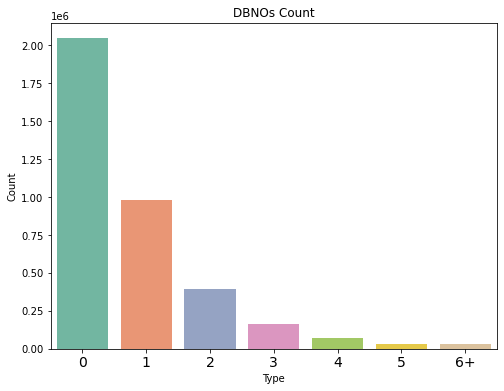

In [41]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_dbnos, palette="Set2")
plt.xticks(fontsize=14)
plt.title("DBNOs Count")
plt.show()

In [42]:
train_group['DBNOs'].describe()

count    3.716372e+06
mean     7.856420e-01
std      1.211465e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.300000e+01
Name: DBNOs, dtype: float64

In [43]:
train_group['DBNOs'].mean()

0.7856420186138524

- 기절시킨 적의 평균수는 0.79이고, 대부분의 사람들이 기절도 못시켰다 

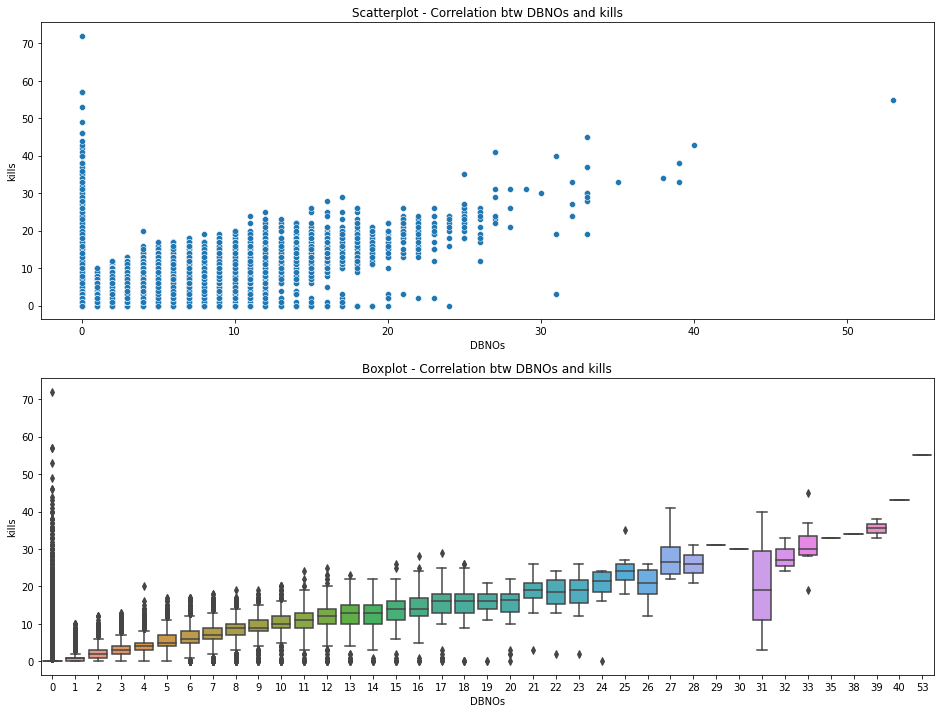

In [119]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train_group, x ="DBNOs", y="kills")
plt.title("Scatterplot - Correlation btw DBNOs and kills")
plt.subplot(212)
sns.boxplot(data=train_group, x ="DBNOs", y="kills")
plt.title("Boxplot - Correlation btw DBNOs and kills")
plt.show()

- 기절시킨 적의 수와 킬수간에는 양의 상관관계를 가진다
- 기절시킨 적의 수가 높을수록 킬로 마무리를 한것으로 보여진다

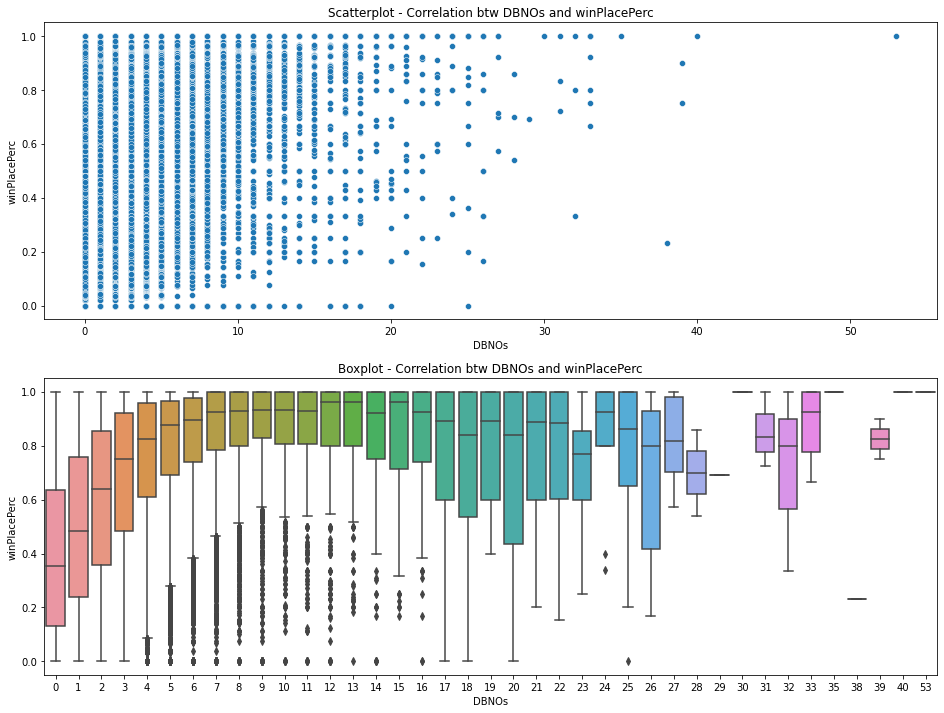

In [121]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train_group, x ="DBNOs", y="winPlacePerc")
plt.title("Scatterplot - Correlation btw DBNOs and winPlacePerc")
plt.subplot(212)
sns.boxplot(data=train_group, x ="DBNOs", y="winPlacePerc")
plt.title("Boxplot - Correlation btw DBNOs and winPlacePerc")
plt.show()

- 기절시킨 적의 수와 승리간에는 어느정도 양의 상관관계를 가지는것 같다
- 대다수의 사람들이 기절도 못시켰던것으로 보인다 

#### HeadshotKills

In [46]:
train['headshotKills'].quantile(0.99)

3.0

In [47]:
train['headshotKills'].value_counts()

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
23          3
20          3
26          3
31          2
34          2
27          2
21          2
41          1
64          1
40          1
39          1
46          1
42          1
35          1
Name: headshotKills, dtype: int64

In [48]:
headshot = train.copy()
headshot.loc[headshot['headshotKills'] >= 4] = '4+'
train_headshot = headshot.loc[:,"headshotKills"].value_counts().to_frame().reset_index()
train_headshot.columns = ["Type","Count"]
train_headshot

,Type,Count
0,0,3696115
1,1,574741
2,2,126348
3,3,32975
4,4+,16786


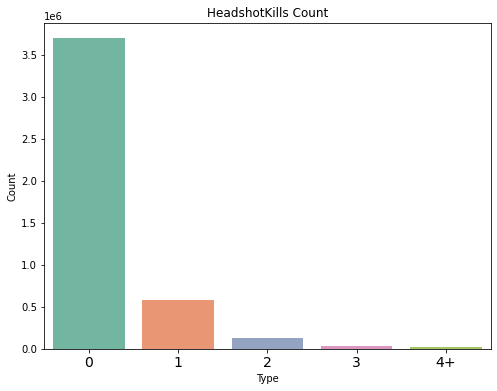

In [49]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_headshot, palette="Set2")
plt.xticks(fontsize=14)
plt.title("HeadshotKills Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

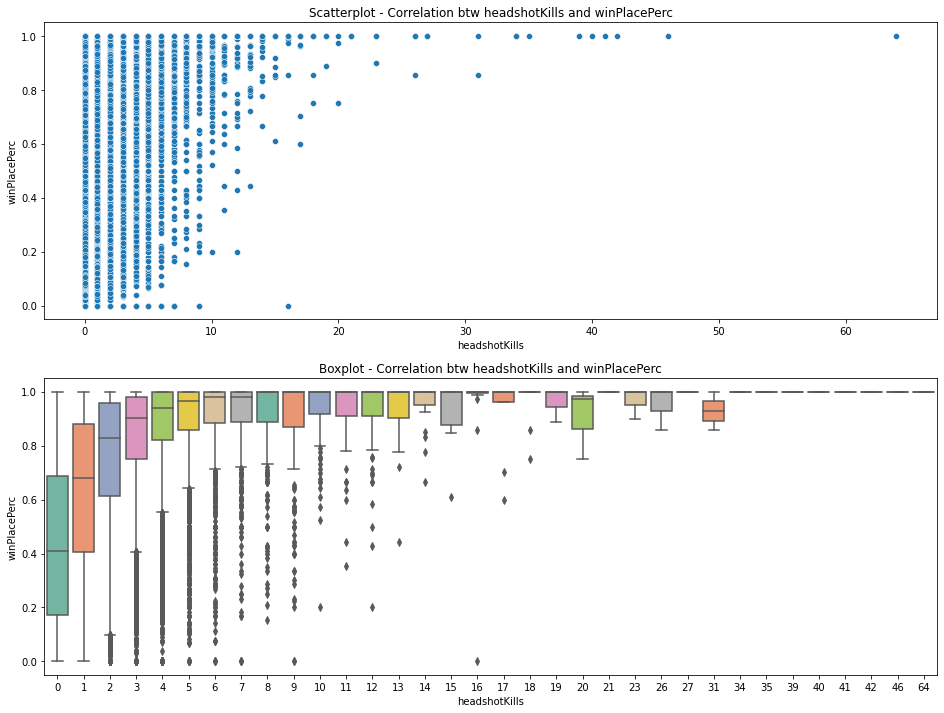

In [122]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x="headshotKills", y="winPlacePerc", palette="Set2")
plt.title("Scatterplot - Correlation btw headshotKills and winPlacePerc")
plt.subplot(212)
sns.boxplot(data=train, x="headshotKills", y="winPlacePerc", palette="Set2")
plt.title("Boxplot - Correlation btw headshotKills and winPlacePerc")
plt.show

- 뚜렷한 상관관계는 보이지 않는다

#### Longestkill

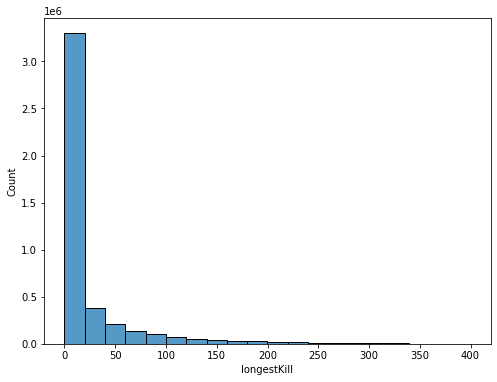

In [124]:
range = train[train['longestKill']<400]
plt.figure(figsize=(8,6))
sns.histplot(data=range, x='longestKill', bins=20)
plt.show()

In [52]:
train['longestKill'].describe()

count    4.446965e+06
mean     2.299760e+01
std      5.097262e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.132000e+01
max      1.094000e+03
Name: longestKill, dtype: float64

In [53]:
train[train['longestKill'] == 0]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
6,0,0,0.00,0,0,0,96,1262,0,0,...,0,0.0000,0,0.000,0,0,13.50,1,1497,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446958,0,0,0.00,0,0,0,92,0,0,0,...,0,0.0000,0,0.000,0,0,0.00,0,0,0.0000
4446959,0,0,22.68,0,0,0,89,0,0,0,...,0,0.0000,0,0.000,0,0,40.25,1,0,0.0842
4446961,0,0,0.00,0,0,0,74,1029,0,0,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,0,1,44.15,0,0,0,69,0,0,0,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935


- 킬을 할때까지 최대의 거리는 1094m이다
- 킬을 할때까지 거리의 평균은 23m이다
- 킬을 할때까지 거리가 0인 값들은 nan값을 0으로 전처리 해줬을 가능성이 있다

#### KIllStreaks

In [54]:
train['killStreaks'].quantile(0.99)

3.0

In [55]:
train['killStreaks'].value_counts()

0     2529721
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
13          5
12          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64

In [56]:
streaks = train.copy()
streaks.loc[streaks['killStreaks'] >= 4] = '4+'
train_streaks = streaks.loc[:,"killStreaks"].value_counts().to_frame().reset_index()
train_streaks.columns = ["Type","Count"]
train_streaks

,Type,Count
0,0,2529721
1,1,1475558
2,2,389346
3,3,45958
4,4+,6382


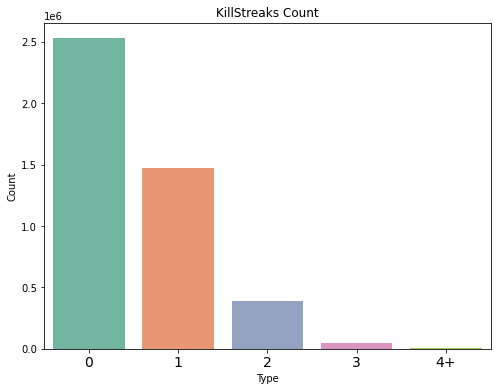

In [57]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_streaks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("KillStreaks Count")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

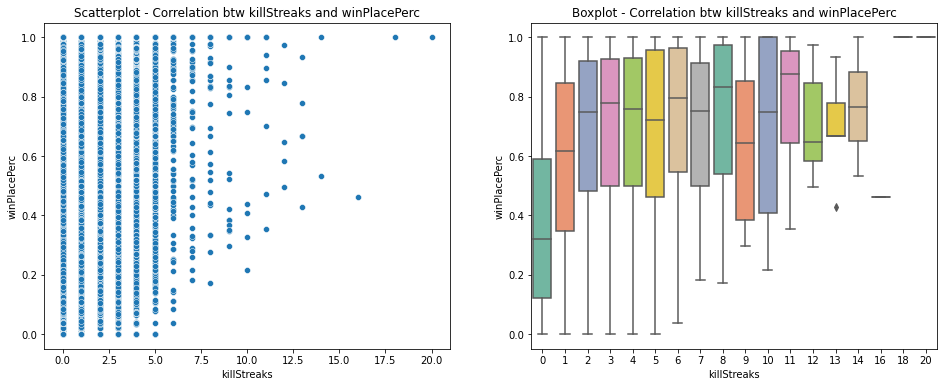

In [99]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train, x="killStreaks", y="winPlacePerc", palette="Set2")
plt.title("Scatterplot - Correlation btw killStreaks and winPlacePerc")
plt.subplot(1,2,2)
sns.boxplot(data=train, x="killStreaks", y="winPlacePerc", palette="Set2")
plt.title("Boxplot - Correlation btw killStreaks and winPlacePerc")
plt.show

- 짧은 시간내에 적을 죽인 수가 많을수록 승리할 확률이 높아지는것 같다 

#### teamKills

In [87]:
train_group['teamKills'].quantile(0.99)

1.0

In [86]:
train_group['teamKills'].value_counts()

0     3628318
1       79933
2        7203
3         826
4          80
5           6
10          2
7           1
12          1
6           1
8           1
Name: teamKills, dtype: int64

In [101]:
teamKills = train.copy()
teamKills.loc[teamKills['teamKills'] >= 4] = '4+'
train_tks= teamKills.loc[:,"teamKills"].value_counts().to_frame().reset_index()
train_tks.columns = ["Type","Count"]
train_tks

,Type,Count
0,0,4350035
1,1,88771
2,2,7236
3,3,829
4,4+,94


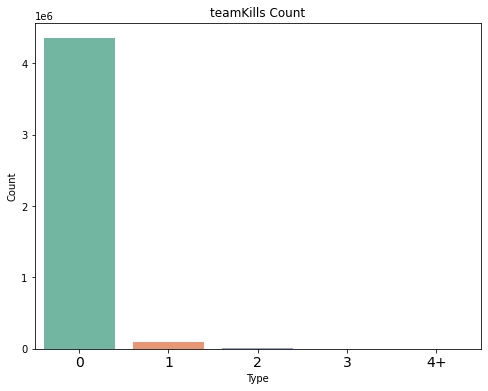

In [102]:
plt.figure(figsize=(8,6))
sns.barplot(x="Type", y="Count", data=train_tks, palette="Set2")
plt.xticks(fontsize=14)
plt.title("teamKills Count")
plt.show()

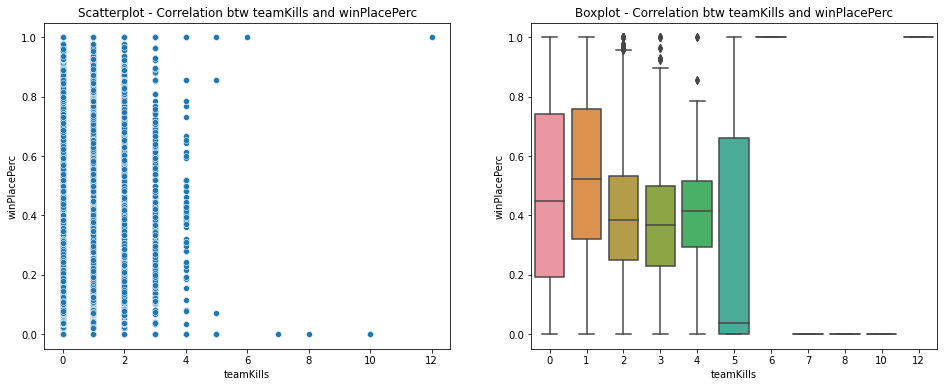

In [125]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train_group, x='teamKills', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw teamKills and winPlacePerc")
plt.subplot(1,2,2)
sns.boxplot(data=train_group, x='teamKills', y='winPlacePerc')
plt.title("Boxplot - Correlation btw teamKills and winPlacePerc")
plt.show()

- teamkill의 수가 거의 없어서 승리와의 상관관계는 없다고 보여진다

### Heals & Boosts

In [59]:
heals = train['heals'].quantile(0.99)
boosts = train['boosts'].quantile(0.99)
print(heals, boosts)

12.0 7.0


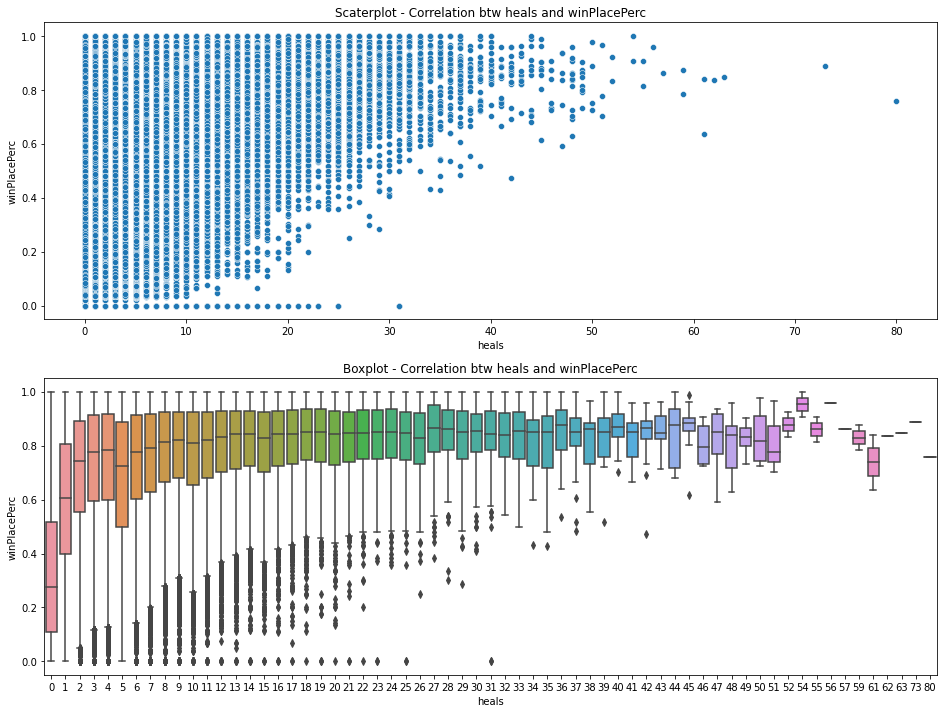

In [126]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='heals', y='winPlacePerc')
plt.title("Scaterplot - Correlation btw heals and winPlacePerc")
plt.subplot(212)
sns.boxplot(data=train, x='heals', y='winPlacePerc')
plt.title("Boxplot - Correlation btw heals and winPlacePerc")
plt.show()

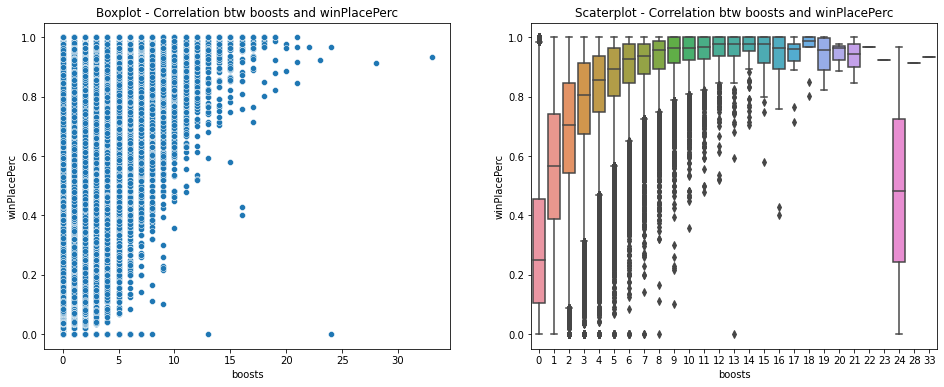

In [128]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.scatterplot(data=train, x='boosts', y='winPlacePerc')
plt.title("Boxplot - Correlation btw boosts and winPlacePerc")
plt.subplot(122)
sns.boxplot(data=train, x='boosts', y='winPlacePerc')
plt.title("Scaterplot - Correlation btw boosts and winPlacePerc")
plt.show()

In [62]:
train[['heals', 'boosts']].describe()

,heals,boosts
count,4.446965e+06,4.446965e+06
mean,1.370148e+00,1.106908e+00
std,2.679982e+00,1.715794e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00
max,8.000000e+01,3.300000e+01


- Heals와 boosts 모두 양의 상관관계를 보인다
- Heals 평균 사용 횟수는 1.3이고, 대다수의 사람들이 하나도 사용하지 못했다 
- Boosts 평균 사용 횟수는 1.1이고, 대다수의 사람들이 하나도 사용하지 못했다
- 이는, 시작하자 마자 죽어서 아이템들을 사용할 기회가 없었던 것으로 예상된다

### WalkDistance & SwimDistance & RideDistance & WeaponAcquired

#### walkDistance

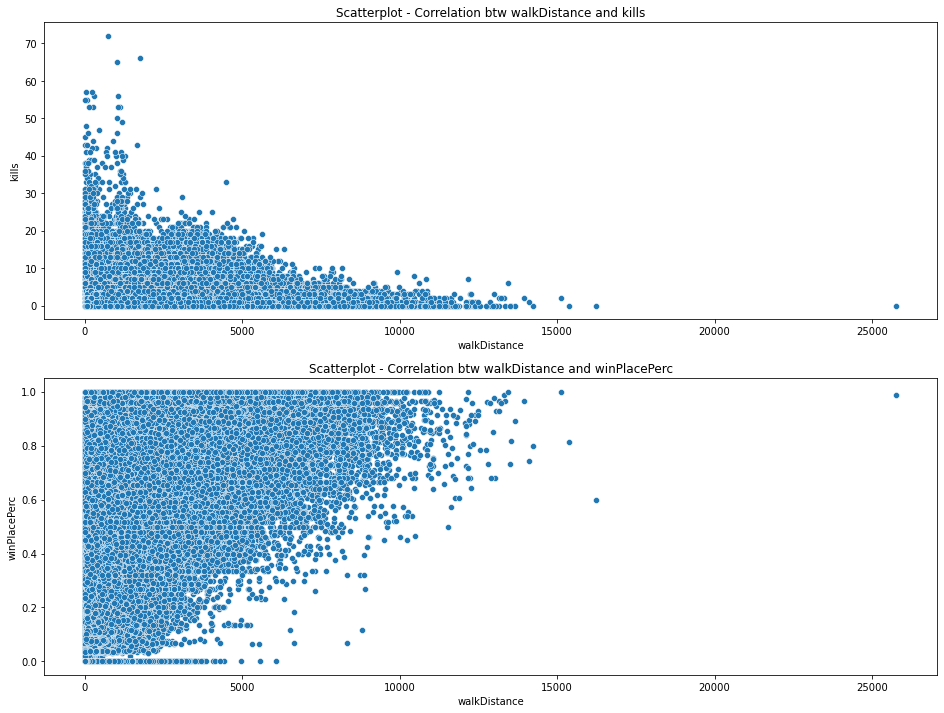

In [133]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='walkDistance', y='kills')
plt.title("Scatterplot - Correlation btw walkDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='walkDistance', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw walkDistance and winPlacePerc")
plt.show()

- 걸은 거리가 많을수록 킬수가 높은것만은 아닌것으로 보여진다
- 오히려 걸은 거리가 적은 사람들중에 킬수가 많은 사람들이 많은 것으로 보여진다
- 걸은 거리와 승률과의 관계에서 어느정도 양의 상관관계를 보인다

In [64]:
train[train['walkDistance'] > 20000]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
497965,0,0,0.0,0,0,0,46,0,0,0,...,0,0.0078,0,381.9,0,0,25780.0,0,0,0.9894


- 걸은 거리가 25780.0인 사람은 걷거나 수영만 했고 아이템을 파밍하지도 않았고 아무도 안만나서 데미지도 없는 것으로 보아 맵탐방을 하지 않았을까 예상이된다 
- 그럼에도 불구하고 승리는 못했지만 높은 등수를 차지한것으로 보인다

##### 이동하지 않았는데 아이템을 획득한 사람들

In [66]:
train[(train.walkDistance == 0) & (train.weaponsAcquired != 0)][['walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,walkDistance,weaponsAcquired,damageDealt,kills
711,0.0,1,0.00,0
846,0.0,6,0.00,0
1357,0.0,15,722.80,0
1433,0.0,1,85.60,0
1814,0.0,1,0.00,0
...,...,...,...,...
4446464,0.0,1,0.00,0
4446682,0.0,4,41.95,1
4446786,0.0,1,0.00,0
4446812,0.0,1,0.00,0


In [67]:
train[(train.walkDistance == 0) & (train.kills > 1)][['walkDistance', 'weaponsAcquired', 'damageDealt', 'kills']]

,walkDistance,weaponsAcquired,damageDealt,kills
1824,0.0,8,593.0,6
6673,0.0,22,346.6,3
11892,0.0,13,1750.0,20
20881,0.0,8,506.1,6
23298,0.0,8,1124.0,12
...,...,...,...,...
4429697,0.0,31,645.6,5
4436511,0.0,8,221.6,5
4437516,0.0,24,361.7,5
4440927,0.0,7,909.1,6


- 이사람들은 불법 프로그램 사용자들일까?
- 낙하산에서 내리자마자 그자리에 아이템이 있어서 먹을 수도 있지만, 움직이지도 않고 킬을 여러개(1킬이상) 한것은 의심스러워 보인다 

#### swimDistance

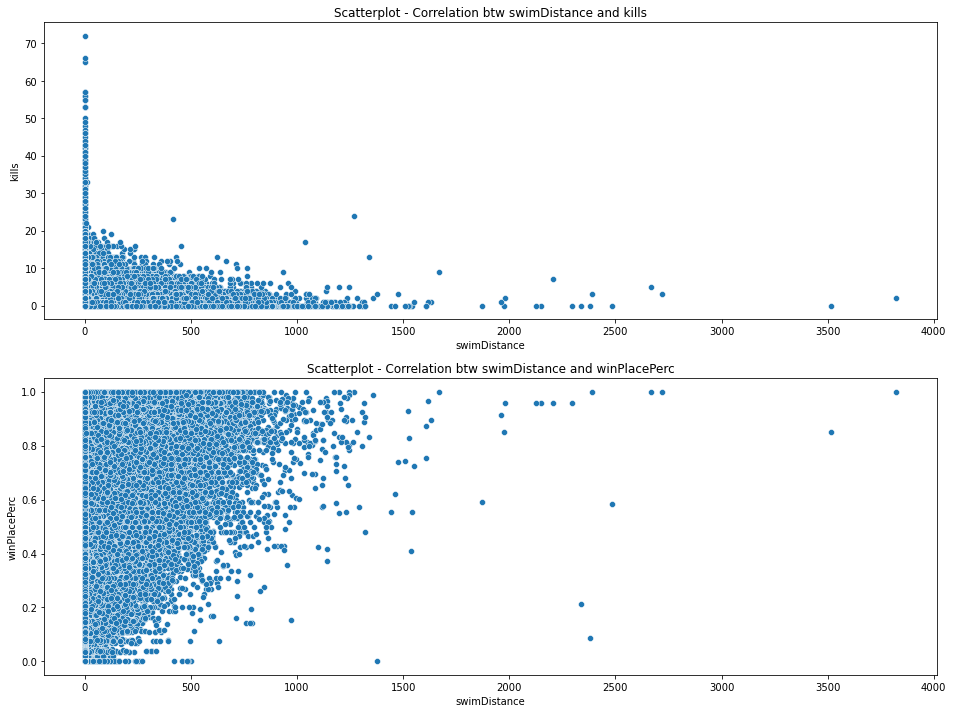

In [134]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='swimDistance', y='kills')
plt.title("Scatterplot - Correlation btw swimDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='swimDistance', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw swimDistance and winPlacePerc")
plt.show()

- 수영한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 수영한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

#### rideDistance

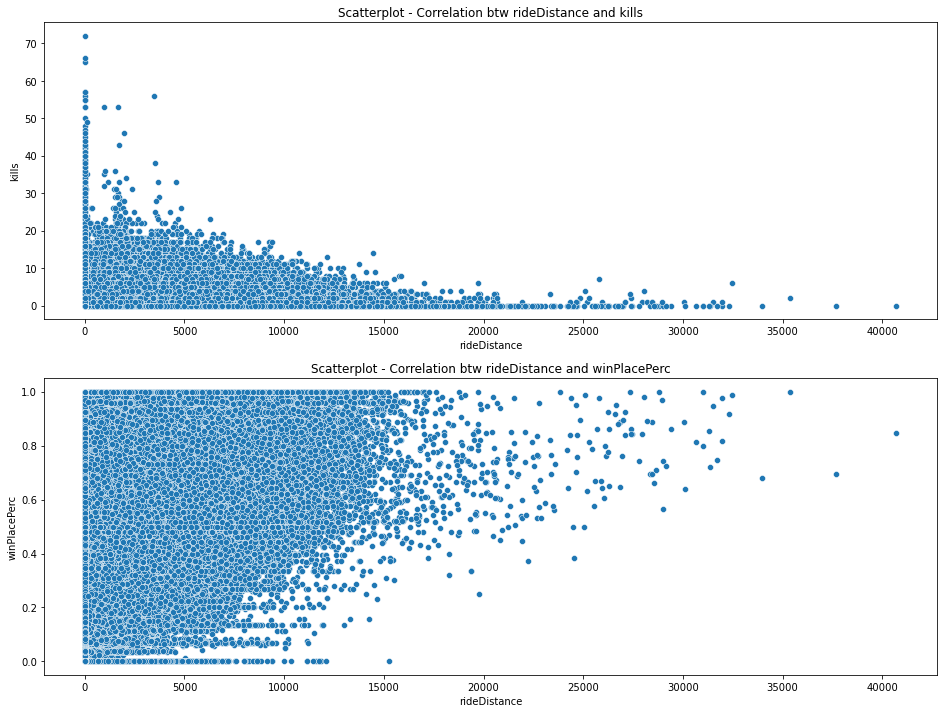

In [135]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='rideDistance', y='kills')
plt.title("Scatterplot - Correlation btw rideDistance and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='rideDistance', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw rideDistance and winPlacePerc")
plt.show()

- 이동수단으로 이동한 거리와 킬과의 상관관계는 음의 상관관계를 가진다
- 이동수단으로 이동한 거리와 승리와의 상관관계는 양의 상관관계를 가진다 

#### weaponsAcquired

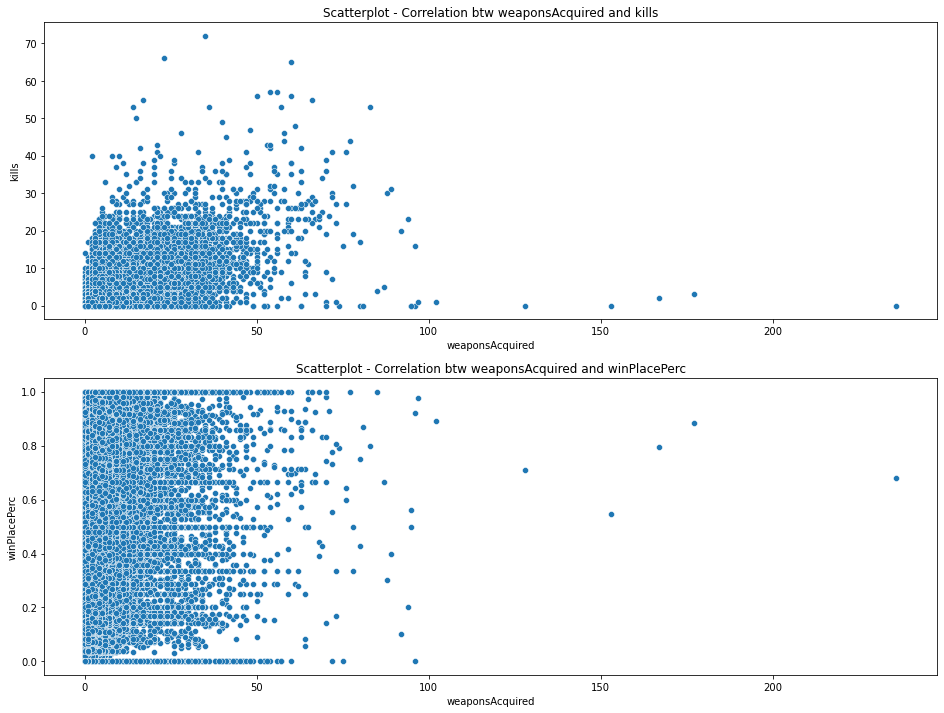

In [137]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.scatterplot(data=train, x='weaponsAcquired', y='kills')
plt.title("Scatterplot - Correlation btw weaponsAcquired and kills")
plt.subplot(212)
sns.scatterplot(data=train, x='weaponsAcquired', y='winPlacePerc')
plt.title("Scatterplot - Correlation btw weaponsAcquired and winPlacePerc")
plt.show()

- 아이템 획득수와 킬 또는 승리와의 뚜렷한 상관관계는 보이지 않는다

##### 무기없이 주먹으로 킬한 사람들

In [68]:
train[(train.weaponsAcquired == 0) & (train.kills != 0)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1627,0,0,100.0,1,0,0,38,1104,1,1,...,0,0.0,0,0.0,0,0,45.970,0,1521,0.3214
3946,0,0,100.0,0,0,0,43,0,1,1,...,0,0.0,0,0.0,0,0,32.920,0,0,0.1771
7259,0,0,200.0,5,2,0,14,0,2,2,...,0,259.2,0,0.0,3,0,177.300,0,0,0.1200
7559,0,0,100.0,1,0,0,37,0,1,1,...,0,0.0,0,0.0,0,0,116.700,0,0,0.0833
8103,0,0,100.0,1,1,0,43,0,1,1,...,0,0.0,0,0.0,0,0,25.540,0,0,0.0213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441281,0,0,300.0,2,0,0,4,0,3,2,...,0,7771.0,3,0.0,0,0,125.900,0,0,0.9149
4444332,0,0,100.0,1,1,0,37,1000,1,1,...,0,0.0,0,0.0,0,0,4.266,0,1500,0.0208
4444788,0,0,100.0,1,0,0,29,0,1,1,...,0,1286.0,1,0.0,0,0,154.200,0,0,0.5000
4445403,0,0,11.6,1,0,0,33,0,1,1,...,0,0.0,0,0.0,0,0,256.500,0,0,0.1200


In [69]:
print(len(train[(train.weaponsAcquired == 0) & (train.kills != 0)]))

3310


- 무기를 획득하지 않고 kill수를 획득한 사람들(3310)은 주먹으로 싸워서 이긴것 같다 

### MatchType

In [70]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

In [71]:
train_mt = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
train_mt.columns = ["Type","Count"]
train_mt

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


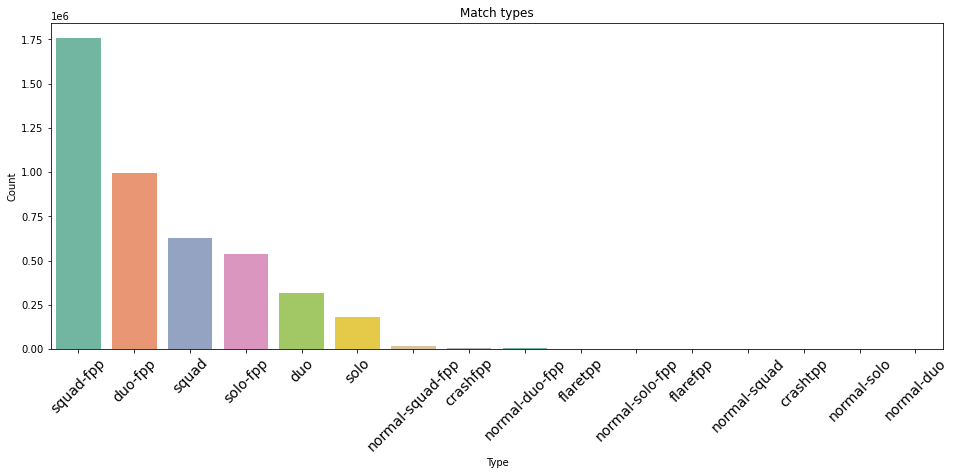

In [72]:
plt.figure(figsize=(16,6))
sns.barplot(x="Type", y="Count", data=train_mt, palette="Set2")
plt.xticks(rotation=45, fontsize=14)
plt.title("Match types")
plt.show()

- Squad-fpp 모드와 duo-fpp 모드가 제일 많은것으로 보인다

In [73]:
temp = train.loc[:,"matchType"].value_counts().to_frame()
squad = temp.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
duo = temp.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
solo = temp.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
match_type = pd.DataFrame([squad,duo,solo], index=["squad","duo","solo"], columns =["count"])
match_type

,count
squad,2400402
duo,1315970
solo,720712


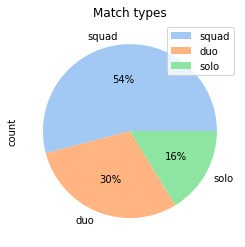

In [74]:
palette = sns.color_palette('pastel')
match_type.plot.pie(y="count", colors=palette, autopct='%.0f%%');
plt.title("Match types")
plt.show()

- Squad 경기수가 제일 많고 그다음으로 duo, solo로 많다.

## 전처리

### 다중공선성 확인

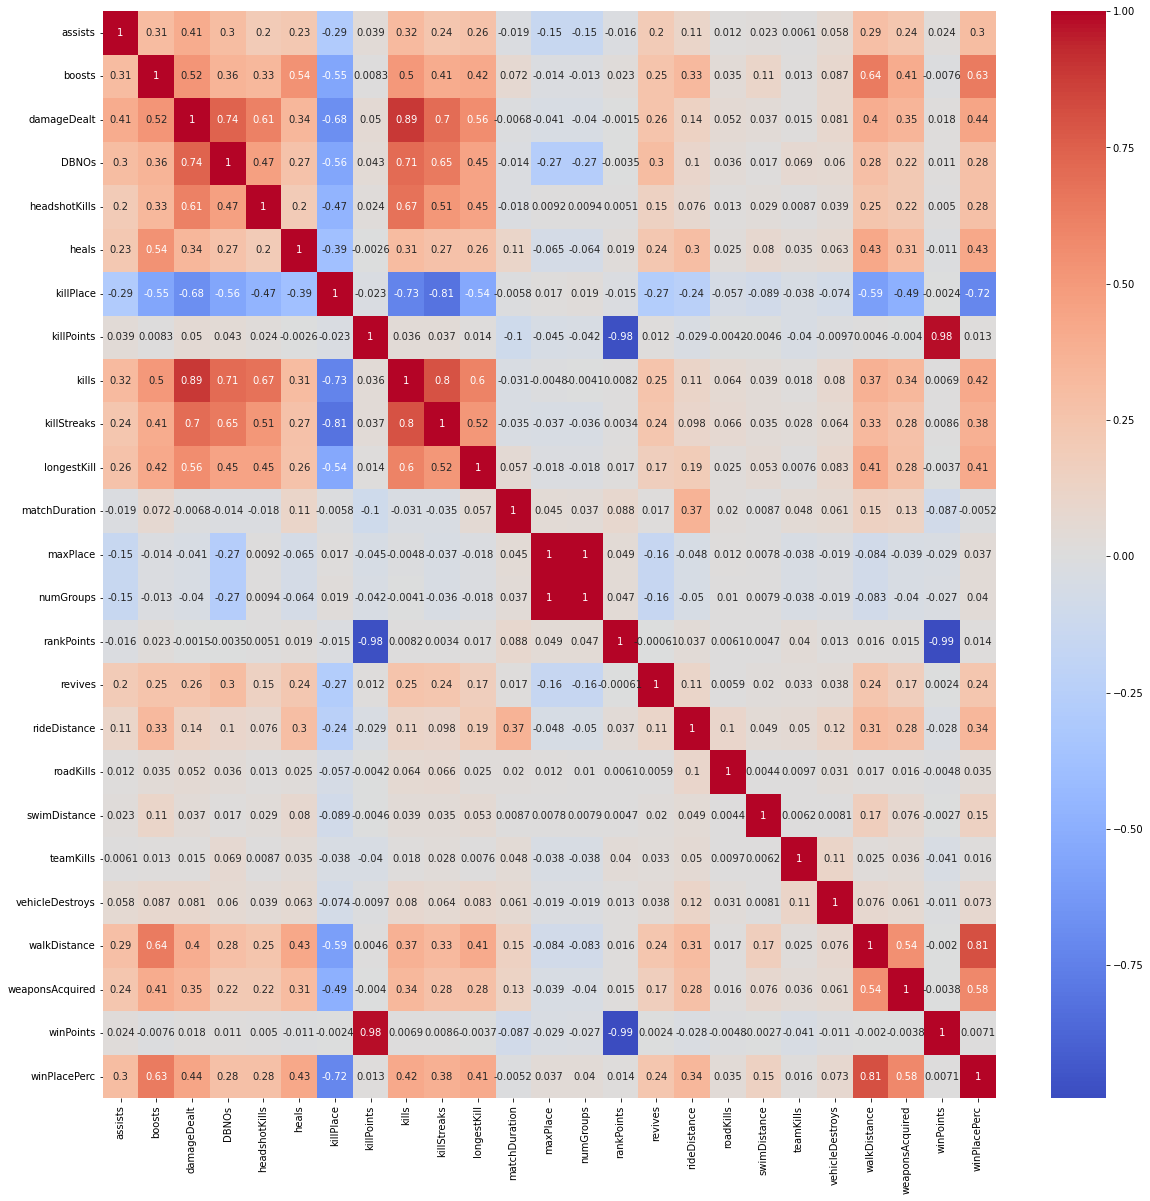

In [75]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)
plt.show()

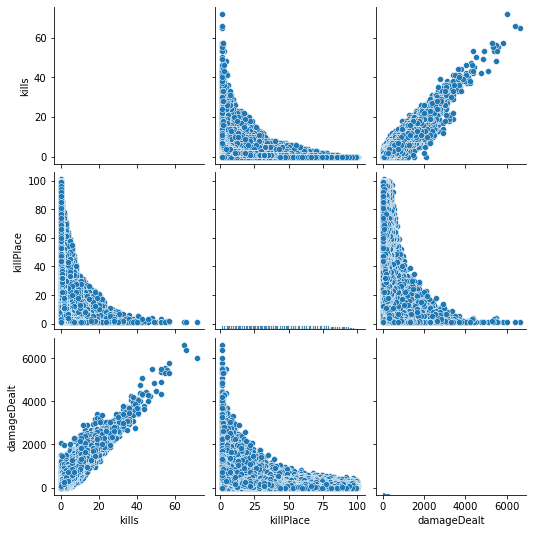

In [78]:
sns.pairplot(train[['kills','killPlace','damageDealt']]);

In [138]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif['VIF Factor'] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
# vif['features'] = train.columns
# vif

In [139]:
#train = train.drop([ "maxPlace", "rankPoints", "killPoints"], axis=1)

In [140]:
#train = train.drop([ "killPlace", "damageDealt"], axis=1)